## Naive Bayes on Political Text

In this notebook we use Naive Bayes to explore and classify political data. See the `README.md` for full details.

In [316]:
import sqlite3
import nltk
import random
import numpy as np
from collections import Counter, defaultdict

# Adding additional Libraries Here.
from string import punctuation
from nltk.corpus import stopwords
import re
import emoji

In [332]:
# Feel free to include your text patterns functions
#from text_functions_solutions import clean_tokenize, get_patterns

# # Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"/s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, top_n_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """
    # Place your Module 2 solution here
    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = ld.ttr(tokens) # Simple TTR = len(Counter(text))/len(text)
    num_characters = sum([len(i) for i in tokens])
    
    if verbose:        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(f"The top {top_n_tokens} most common tokens")
        print(Counter(tokens).most_common(top_n_tokens))
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return([t for t in tokens if t.lower() not in sw])
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return text.lower().strip().split()

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

In [318]:
db_location = r"C:\Users\zfreitas\Dropbox\Classes\USD\ADS-509-01-SP23 - Applied Text Mining\git\Data"
db_filename = r"\2020_Conventions.db"
convention_db = sqlite3.connect(db_location + db_filename)
convention_cur = convention_db.cursor()

### Part 1: Exploratory Naive Bayes

We'll first build a NB model on the convention data itself, as a way to understand what words distinguish between the two parties. This is analogous to what we did in the "Comparing Groups" class work. First, pull in the text 
for each party and prepare it for use in Naive Bayes.  

In [320]:
query_results = convention_cur.execute(
                            '''
                            SELECT name FROM sqlite_schema
WHERE type='table'
ORDER BY name;
                            ''')

#Fetching 1st row from the table
# result = cursor.fetchone();
# print(result)

#Fetching all rows from the table
result = convention_cur.fetchall();
print(result)

[('conventions',)]


In [321]:
query_results = convention_cur.execute(
                            '''
                            PRAGMA table_info(conventions);

                            ''')

#Fetching 1st row from the table
# result = cursor.fetchone();
# print(result)

#Fetching all rows from the table
result = convention_cur.fetchall();
print(result)

[(0, 'party', 'TEXT', 0, None, 0), (1, 'night', 'INTEGER', 0, None, 0), (2, 'speaker', 'TEXT', 0, None, 0), (3, 'speaker_count', 'INTEGER', 0, None, 0), (4, 'time', 'TEXT', 0, None, 0), (5, 'text', 'TEXT', 0, None, 0), (6, 'text_len', 'TEXT', 0, None, 0), (7, 'file', 'TEXT', 0, None, 0)]


In [322]:
query_results = convention_cur.execute(
                            '''
                            SELECT * FROM conventions limit 1
                            ''')

#Fetching 1st row from the table
result = convention_cur.fetchone();
print(result)

('Democratic', 4, 'Unknown', 1, '00:00', 'Skip to content The Company Careers Press Freelancers Blog × Services Transcription Captions Foreign Subtitles Translation Freelancers About Contact Login « Return to Transcript Library home  Transcript Categories  All Transcripts 2020 Election Transcripts Classic Speech Transcripts Congressional Testimony & Hearing Transcripts Debate Transcripts Donald Trump Transcripts Entertainment Transcripts Financial Transcripts Interview Transcripts Political Transcripts Press Conference Transcripts Speech Transcripts Sports Transcripts Technology Transcripts Aug 21, 2020 2020 Democratic National Convention (DNC) Night 4 Transcript Rev  ›  Blog  ›  Transcripts  › 2020 Election Transcripts  ›  2020 Democratic National Convention (DNC) Night 4 Transcript Night 4 of the 2020 Democratic National Convention (DNC) on August 20. Read the full transcript of the event here. Transcribe Your Own Content  Try Rev for free  and save time transcribing, captioning, and

In [323]:
query_results = convention_cur.execute(
                            '''
                            SELECT count(*) as count FROM conventions
                            ''')

#Fetching 1st row from the table
result = convention_cur.fetchone();
print(result)

(2541,)


In [333]:
convention_data = []

# fill this list up with items that are themselves lists. The 
# first element in the sublist should be the cleaned and tokenized
# text in a single string. The second element should be the party. 

query_results = convention_cur.execute(
    '''
    SELECT text, party FROM conventions
    ''')

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

for row in query_results :
    # store the results in convention_data
    token_list = prepare(row[0],pipeline=my_pipeline)
    token_str = ' '.join(token_list)
    convention_data.append([token_str, row[1]])
   

print("List Size:", len(convention_data))

List Size: 2541


Let's look at some random entries and see if they look right. 

In [335]:
random.choices(convention_data,k=10)

[['waited months signature piece paper get prosthetic leg fixed it’s lot better turnaround',
  'Republican'],
 ['i’ll president who’ll stand allies friends make clear adversaries days cozing dictators president biden america turn blind eye russia bounties heads american soldiers put foreign interference sacred democratic exercise voting i’ll always stand values human rights dignity i’ll work common purpose secure peaceful prosperous world history thrust one urgent task us generation finally wipes stain racism national character believe we’re believe we’re ready',
  'Democratic'],
 ['fulfilled commander chief role decisively going nation’s enemies know answer yes choice clear important election lifetime next four years decide course country decades come asking stand counted never look back recall like america men women free families secure president served people god bless america thank goodnight',
  'Republican'],
 ['ignored trump flags ignore millions maga banners barns painted red wh

If that looks good, we now need to make our function to turn these into features. In my solution, I wanted to keep the number of features reasonable, so I only used words that occur at least `word_cutoff` times. Here's the code to test that if you want it. 

In [336]:
word_cutoff = 5

tokens = [w for t, p in convention_data for w in t.split()] 
word_dist = nltk.FreqDist(tokens)

feature_words = set()

for word, count in word_dist.items() :
    if count > word_cutoff :
        feature_words.add(word)
        
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words)} as features in the model.")

With a word cutoff of 5, we have 2391 as features in the model.


In [337]:
def conv_features(text,fw) :
    """Given some text, this returns a dictionary holding the
       feature words.
       
       Args: 
            * text: a piece of text in a continuous string. Assumes
            text has been cleaned and case folded.
            * fw: the *feature words* that we're considering. A word 
            in `text` must be in fw in order to be returned. This 
            prevents us from considering very rarely occurring words.
        
       Returns: 
            A dictionary with the words in `text` that appear in `fw`. 
            Words are only counted once. 
            If `text` were "quick quick brown fox" and `fw` = {'quick','fox','jumps'},
            then this would return a dictionary of 
            {'quick' : True,
             'fox' :    True}
        
    """
    
    
    ret_dict = dict()

    # Your code here
    words = set(text.split())
    for word in words:
        if word in set(fw):
            ret_dict[word] = True
          
    return(ret_dict)

In [338]:
conv_features("donald is the president",feature_words)

{'president': True, 'donald': True}

In [339]:
assert(len(feature_words)>0)
assert(conv_features("donald is the president",feature_words)==
       {'donald':True,'president':True})
assert(conv_features("people are american in america",feature_words)==
                     {'america':True,'american':True,"people":True})

Now we'll build our feature set. Out of curiosity I did a train/test split to see how accurate the classifier was, but we don't strictly need to since this analysis is exploratory. 

In [340]:
featuresets = [(conv_features(text,feature_words), party) for (text, party) in convention_data]

In [341]:
random.seed(20220507)
random.shuffle(featuresets)

test_size = 500

In [342]:
test_set, train_set = featuresets[:test_size], featuresets[test_size:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.5


In [343]:
classifier.show_most_informative_features(25)

Most Informative Features
                   china = True           Republ : Democr =     25.8 : 1.0
                   votes = True           Democr : Republ =     23.8 : 1.0
             enforcement = True           Republ : Democr =     21.5 : 1.0
                 destroy = True           Republ : Democr =     19.2 : 1.0
                freedoms = True           Republ : Democr =     18.2 : 1.0
                 climate = True           Democr : Republ =     17.8 : 1.0
                supports = True           Republ : Democr =     17.1 : 1.0
                   crime = True           Republ : Democr =     16.1 : 1.0
                   media = True           Republ : Democr =     14.9 : 1.0
                 beliefs = True           Republ : Democr =     13.0 : 1.0
               countries = True           Republ : Democr =     13.0 : 1.0
                 defense = True           Republ : Democr =     13.0 : 1.0
                    isis = True           Republ : Democr =     13.0 : 1.0

Write a little prose here about what you see in the classifier. Anything odd or interesting?

### My Observations

I find it striking that democrats only have two informative features of the top 25 features, and they are ‘votes’ and ‘climate’. Those issues just are not as important to the republican party. It is also interesting that the republicans hold 23 of the topmost informative features, for example ‘china’, ‘enforcement’, and ‘freedom’.  I think another analysis that would be interesting is to see is where there is common ground. I’m not sure we would find any in this data, but I know them to exist. I think it would be interesting to take what the other side deems important and try to show how you share common interests in their issues, but I feel that division is all that works and is why people tend to rely on it as a political tactic. For example, I’m sure democrats believe in freedom, religion, flag, and detest crime. They are just not talking about it.



## Part 2: Classifying Congressional Tweets

In this part we apply the classifer we just built to a set of tweets by people running for congress
in 2018. These tweets are stored in the database `congressional_data.db`. That DB is funky, so I'll
give you the query I used to pull out the tweets. Note that this DB has some big tables and 
is unindexed, so the query takes a minute or two to run on my machine.

In [344]:
db_location = r"C:\Users\zfreitas\Dropbox\Classes\USD\ADS-509-01-SP23 - Applied Text Mining\git\Data"
db_filename = r"\congressional_data.db"

cong_db = sqlite3.connect(db_location + db_filename)
cong_cur = cong_db.cursor()

In [345]:
results = cong_cur.execute(
        '''
           SELECT DISTINCT 
                  cd.candidate, 
                  cd.party,
                  tw.tweet_text
           FROM candidate_data cd 
           INNER JOIN tweets tw ON cd.twitter_handle = tw.handle 
               AND cd.candidate == tw.candidate 
               AND cd.district == tw.district
           WHERE cd.party in ('Republican','Democratic') 
               AND tw.tweet_text NOT LIKE '%RT%'
        ''')

results = list(results) # Just to store it, since the query is time consuming

In [346]:
tweet_data = []

# Now fill up tweet_data with sublists like we did on the convention speeches.
# Note that this may take a bit of time, since we have a lot of tweets.

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

for row in results :
    # store the results in convention_data
    text=row[2].decode()
    token_list = prepare(text, pipeline=my_pipeline)
    token_str = ' '.join(token_list)
    tweet_data.append([token_str, row[1]])
   

print("List Size:", len(tweet_data))

List Size: 664656


There are a lot of tweets here. Let's take a random sample and see how our classifer does. I'm guessing it won't be too great given the performance on the convention speeches...

In [347]:
random.seed(20201014)

tweet_data_sample = random.choices(tweet_data,k=10)

In [348]:

for tweet, party in tweet_data_sample :
    feature_inputs = (conv_features(tweet,feature_words), party)[0]
    estimated_party = classifier.classify(feature_inputs)
    # Fill in the right-hand side above with code that estimates the actual party
    
    print(f"Here's our (cleaned) tweet: {tweet}")
    print(f"Actual party is {party} and our classifer says {estimated_party}.")
    print("")
    

Here's our (cleaned) tweet: earlier today spoke house floor abt protecting health care women praised ppmarmonte work central coast httpstcowqgtrzt7vv
Actual party is Democratic and our classifer says Republican.

Here's our (cleaned) tweet: go tribe #rallytogether httpstco0nxutfl9l5
Actual party is Democratic and our classifer says Democratic.

Here's our (cleaned) tweet: apparently trump thinks easy students overwhelmed crushing burden debt pay student loans #trumpbudget httpstcockyqo5t0qh
Actual party is Democratic and our classifer says Republican.

Here's our (cleaned) tweet: we’re grateful first responders rescue personnel firefighters police volunteers working tirelessly keep people safe provide muchneeded help putting lives line httpstcoezpv0vmiz3
Actual party is Republican and our classifer says Republican.

Here's our (cleaned) tweet: let’s make even greater #kag 🇺🇸 httpstcoy9qozd5l2z
Actual party is Republican and our classifer says Republican.

Here's our (cleaned) tweet: 1h

Now that we've looked at it some, let's score a bunch and see how we're doing.

In [349]:
# dictionary of counts by actual party and estimated party. 
# first key is actual, second is estimated
parties = ['Republican','Democratic']
results = defaultdict(lambda: defaultdict(int))

for p in parties :
    for p1 in parties :
        results[p][p1] = 0


num_to_score = 10000
random.shuffle(tweet_data)

for idx, tp in enumerate(tweet_data) :
    tweet, party = tp    
    # Now do the same thing as above, but we store the results rather
    # than printing them. 
   
    # get the estimated party
    feature_inputs = (conv_features(tweet,feature_words), party)[0]
    estimated_party = classifier.classify(feature_inputs)
    
    results[party][estimated_party] += 1
    
    if idx > num_to_score : 
        break

In [350]:
results

defaultdict(<function __main__.<lambda>()>,
            {'Republican': defaultdict(int,
                         {'Republican': 3695, 'Democratic': 583}),
             'Democratic': defaultdict(int,
                         {'Republican': 4817, 'Democratic': 907})})

### Reflections

Our classifier did a fantastic job of finding republicans and democrats. We had an accuracy score of 85.1%. This lack of accuracy makes sense, even a recent Gallup poll finds that close to 42% of united states citizens identify as independent voters. This would make predicting our binary classification inherently have errors built into it. I think an easier way to improve modeling would be to include additional classifications to it like Democratic-leaning independent, Non-leaning independent, and Republican-leaning independent.

$$ Accuracy = {3695 + 4817 \over 583 + 907 + 3695 + 4817} = 85.1\% $$

Jones, J. M. (2022, September 21). U.S. political party preferences shifted greatly during 2021. Gallup.com. Retrieved February 5, 2023, from https://news.gallup.com/poll/388781/political-party-preferences-shifted-greatly-during-2021.aspx 


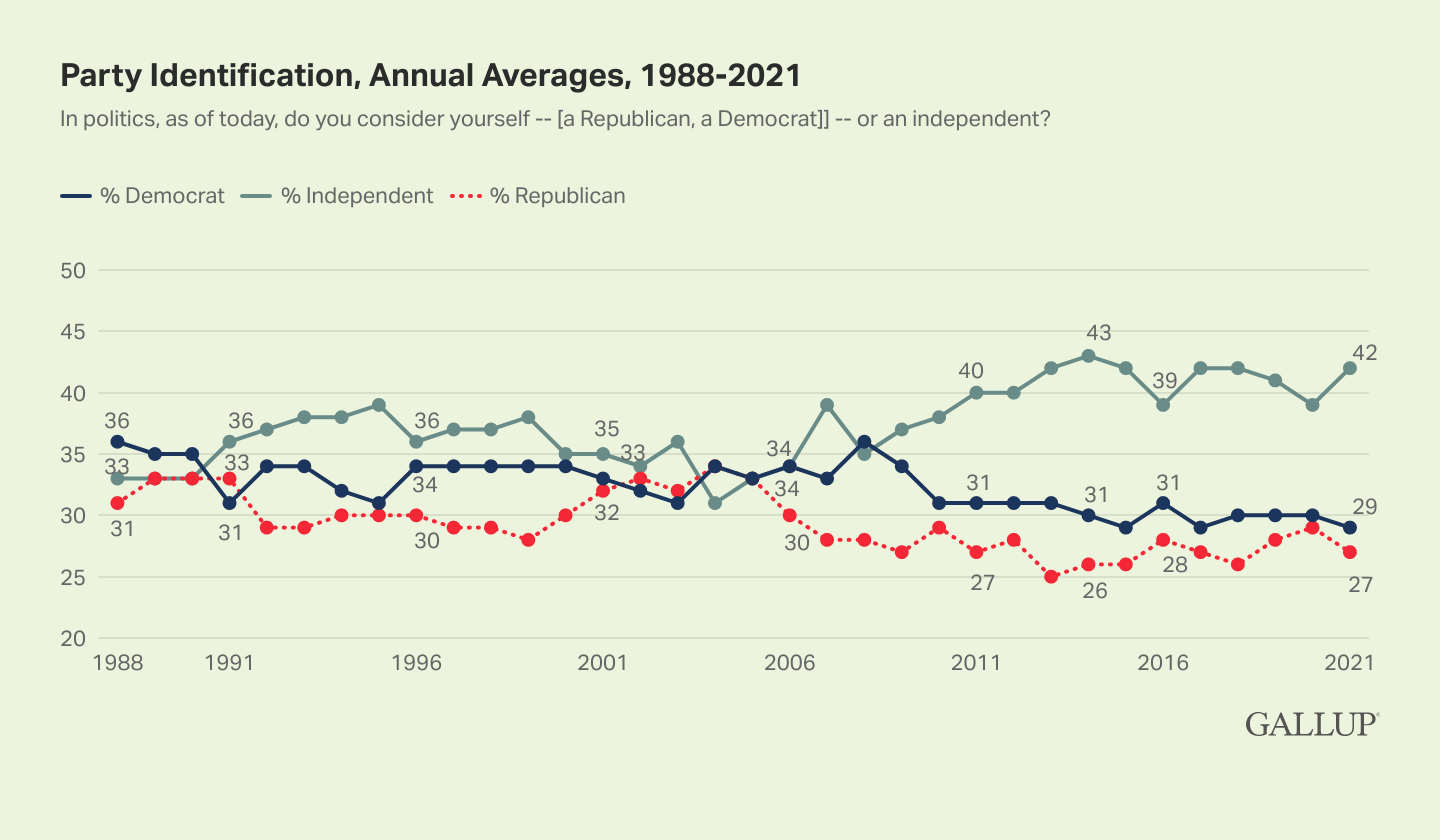